In [89]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error
from pandas.plotting import autocorrelation_plot


In [90]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title="Time Series")
    x.rolling(21).mean().plot(ax=axes[0][0], c="k", lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.4f}\nADF_p_value: {adfuller(x)[1]:>11.4f}"
    axes[0][0].text(x=0.02, y=0.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f"Mean: {mean:>12.4f}\nSD: {np.sqrt(var):>16.4f}\nSkew: {skew:12.4f}\nKurtosis:{kurtosis:9.4f}"
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel("Lag")
    axes[1][1].set_xlabel("Lag")
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

In [91]:
def test_unit_root(df):
    return df.apply(lambda x: f"{pd.Series(adfuller(x)).iloc[1]:.4}").to_frame(
        "p-value"
    )

In [92]:
# this is our target
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
y_CME3MSOFR["date"] = y_CME3MSOFR["date"].apply(
    lambda x: dt.datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d")
)
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])

In [93]:
start_date = pd.to_datetime("2019-04-01")
end_date = pd.to_datetime("2023-11-01")
print(f"{start_date} & {end_date}")

2019-04-01 00:00:00 & 2023-11-01 00:00:00


In [94]:
# this is our feature -
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = x_3MSOFRFuture["date"].apply(
    lambda x: dt.datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d")
)
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
print(test_unit_root(x_3MSOFRFuture))

                      p-value
date                4.953e-06
price_3MSOFRFuture     0.3702


In [95]:
# USD3MLIBOR
x_USD3MLIBOR = pd.read_csv(f"../data/USD3MLIBOR.csv")
x_USD3MLIBOR = x_USD3MLIBOR.dropna(axis="columns")
x_USD3MLIBOR.columns = ["date", "rate_USD3MLIBOR"]
x_USD3MLIBOR["date"] = x_USD3MLIBOR["date"].apply(
    lambda x: dt.datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d")
)
x_USD3MLIBOR["date"] = pd.to_datetime(x_USD3MLIBOR["date"])
print(test_unit_root(x_USD3MLIBOR))

                   p-value
date             2.538e-10
rate_USD3MLIBOR     0.2622


In [96]:
# USTbill3M
# ah syake
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="rows")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = x_USTbill3M["date"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y").strftime("%Y-%m-%d")
)
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
x_USTbill3M
# print(test_unit_root(x_USTbill3M))

,date,rate_USTbill3M
0,2023-11-22,5.4046
1,2023-11-21,5.3999
2,2023-11-20,5.4029
3,2023-11-17,5.3969
4,2023-11-16,5.3972
...,...,...
1245,2018-11-30,2.3654
1246,2018-11-29,2.3616
1247,2018-11-28,2.3704
1248,2018-11-27,2.3771


In [97]:
# USD3MOIS this is weird data
x_USD3MOIS = pd.read_csv(f"../data/USD3MOIS.csv")
x_USD3MOIS.columns = ["date", "bid", "ask"]
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"]).dt.strftime("%Y-%m-%d")
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"])
x_USD3MOIS["mid_USD3MOIS"] = 0.5 * (x_USD3MOIS["bid"] + x_USD3MOIS["ask"])

print(test_unit_root(x_USD3MOIS))

               p-value
date          0.008842
bid             0.2614
ask             0.2559
mid_USD3MOIS    0.2597


In [98]:
dfs = [y_CME3MSOFR, x_3MSOFRFuture, x_USD3MLIBOR, x_USTbill3M, x_USD3MOIS]
dfs = [df.set_index("date") for df in dfs]
df_concat = dfs[0].join(dfs[1:])
df_concat = df_concat.reset_index()
df_concat.dropna(inplace=True)
df_concat.tail(20)

,date,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,bid,ask,mid_USD3MOIS
1178,2019-02-01,2.4507,97.695,2.73263,2.3895,2.396,2.416,2.406
1179,2019-01-31,2.4542,97.720,2.73750,2.4085,2.396,2.416,2.406
1180,2019-01-30,2.4534,97.650,2.73625,2.4111,2.400,2.420,2.410
1181,2019-01-29,2.4550,97.600,2.74438,2.4063,2.401,2.421,2.411
1182,2019-01-28,2.4611,97.595,2.75050,2.4008,2.401,2.421,2.411
1183,2019-01-25,2.4614,97.585,2.75163,2.3964,2.405,2.425,2.415
1184,2019-01-24,2.4584,97.610,2.76475,2.3881,2.403,2.423,2.413
1185,2019-01-23,2.4568,97.595,2.77063,2.3997,2.404,2.424,2.414
1186,2019-01-22,2.4563,97.600,2.77925,2.4034,2.399,2.419,2.409
1187,2019-01-18,2.4512,97.555,2.76100,2.4002,2.401,2.421,2.411


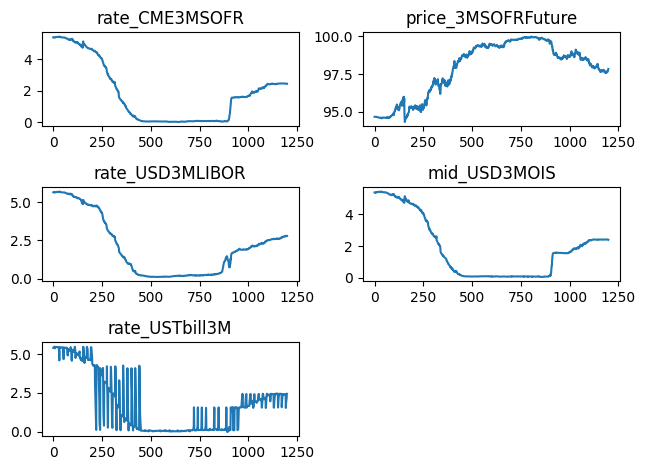

In [99]:
plt.subplot(321)
plt.plot(df_concat["rate_CME3MSOFR"])
plt.title("rate_CME3MSOFR")
plt.subplot(322)
plt.plot(df_concat["price_3MSOFRFuture"])
plt.title("price_3MSOFRFuture")
plt.subplot(323)
plt.plot(df_concat["rate_USD3MLIBOR"])
plt.title("rate_USD3MLIBOR")
plt.subplot(324)
plt.plot(df_concat["mid_USD3MOIS"])
plt.title("mid_USD3MOIS")
plt.subplot(325)
plt.plot(df_concat["rate_USTbill3M"])
plt.title("rate_USTbill3M")
plt.tight_layout()
plt.show()

In [100]:
temp = 


SyntaxError: invalid syntax (1570939987.py, line 1)

In [ ]:
diff = 1
y_CME3MSOFR_transform = y_CME3MSOFR.diff(diff).dropna()
plot_correlogram(y_CME3MSOFR_transform.rate, lags=2)
print(diff)
x_3MSOFRFuture_transform = x_3MSOFRFuture.diff(diff).dropna()
print(test_unit_root(x_3MSOFRFuture_transform))
x_USD3MLIBOR_transform = x_USD3MLIBOR.diff(diff).dropna()
print(test_unit_root(x_USD3MLIBOR_transform))
x_USTbill3M_transform = x_USTbill3M.diff(diff).dropna()
print(test_unit_root(x_USTbill3M_transform))
x_USD3MOIS_transform = x_USD3MOIS.diff(diff).dropna()
print(test_unit_root(x_USD3MOIS_transform))

AttributeError: 'DataFrame' object has no attribute 'rate'

According to https://machinelearningmastery.com/time-series-data-stationary-python/
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

All of our features seem to suggest non-stationarity. Diff by one seems to fix this somewhat

In [ ]:
y_CME3MSOFR_transform
plt.plot(y_CME3MSOFR_transform["rate"])

In [ ]:
y_CME3MSOFR_transform = y_CME3MSOFR_transform.apply(minmax_scale)
plt.plot(y_CME3MSOFR_transform["rate"])